In [90]:
%pip install scikit-learn pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\matej\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [91]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.decomposition import PCA

In [92]:
genes = pd.read_csv("gene_expression.csv",delimiter=";", header=None)
genes = genes.replace(',','.', regex=True)
labels = pd.read_csv("label.csv", header=None)
label_names = ["ALL", "AML"]
feature_names = pd.read_csv('geneNames.txt', header=None)
feature_names = feature_names.T

# Part 1

In [93]:
d_tree = DecisionTreeClassifier()
d_tree.fit(genes,labels)

DecisionTreeClassifier()

Training Accuracy: 1.00


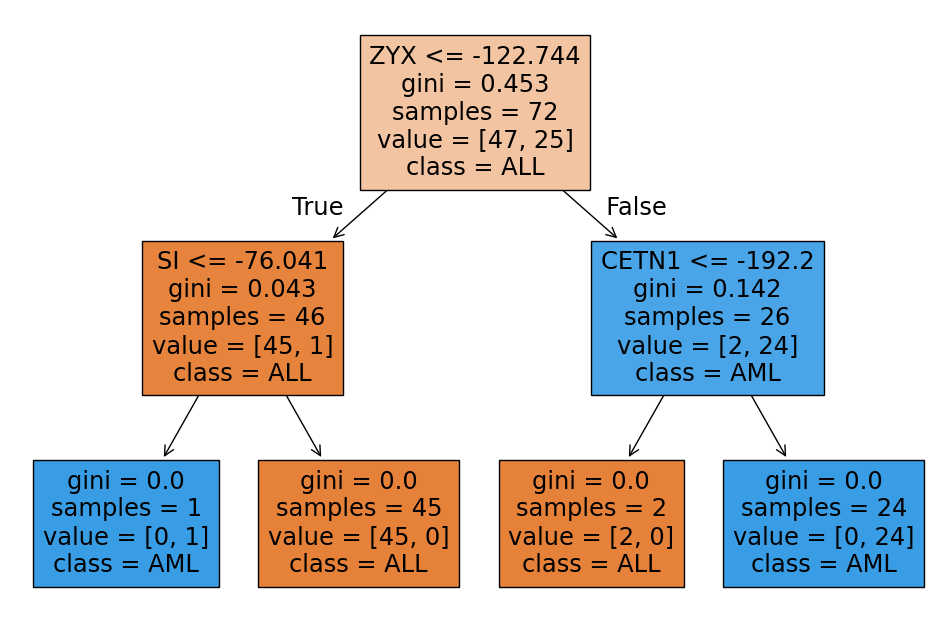

In [94]:
train_acc = d_tree.score(genes,labels)
print(f"Training Accuracy: {train_acc:.2f}")

plt.figure(figsize=(12,8))
plot_tree(d_tree, filled=True, feature_names=feature_names.loc[0], class_names=label_names)
plt.show()

### Interpretace
- Trénovací přesnost modelu je **100%**
- Hlavní gen, podle kterého se model rozhoduje je **XYZ**
- Ve článku ***Golub et al*** zmiňují, že nejvyšší korelací má **HOXA9**

In [95]:
# Crossvalidation 5 folds
crossval_dtree = DecisionTreeClassifier()
acc_scores = cross_val_score(crossval_dtree, genes, labels, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {acc_scores}")
print(f"Mean accuracy: {np.mean(acc_scores):.2f}")
print(f"Standard deviation: {np.std(acc_scores):.2f}")

# Splitting testing and training data
genes_train, genes_test, labels_train, labels_test = train_test_split(genes, labels, test_size=0.2)
test_dtree = DecisionTreeClassifier()
test_dtree.fit(genes_train,labels_train)
train_acc = test_dtree.score(genes_test,labels_test)
print(f"Testing Accuracy: {train_acc:.2f}")

Cross-validation scores: [0.86666667 0.8        0.78571429 0.85714286 0.71428571]
Mean accuracy: 0.80
Standard deviation: 0.06
Testing Accuracy: 0.87


### Srovnání
- přesnost modelu při použití cross validace je přibližně 0.8
- testovací přesnost modelu při rozdělení dat je také přibližně 0.8
- trénovací přesnost původního modelu byla 1
- **Trénovací přesnost neodpovídá realitě, neboť model predikuje data na kterých se učil**

# Part 2

In [96]:
pca = PCA(n_components=min(genes.shape[0], genes.shape[1]))
V = pca.fit(genes).components_
print("Basis matrix V shape:", V.shape)

Basis matrix V shape: (72, 7129)


Top 1 components used
Training Accuracy: 1.00


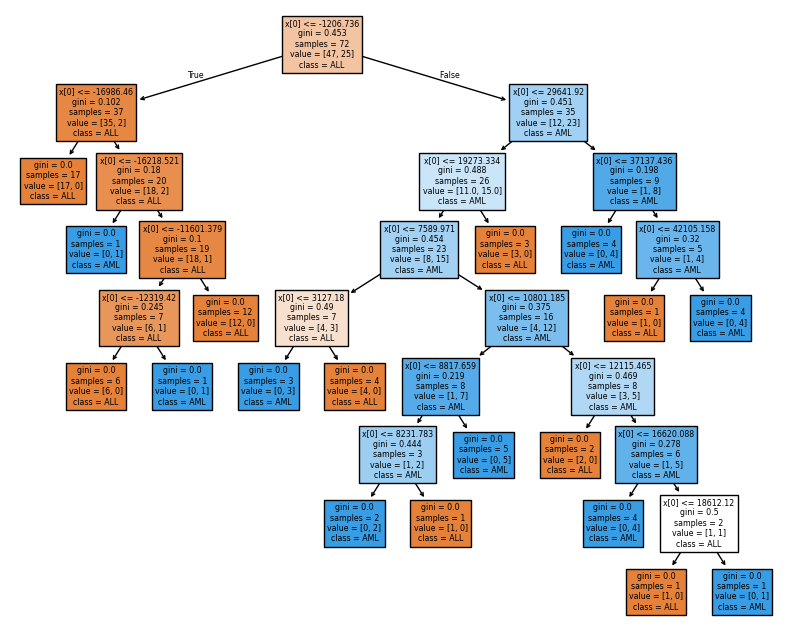

Top 2 components used
Training Accuracy: 1.00


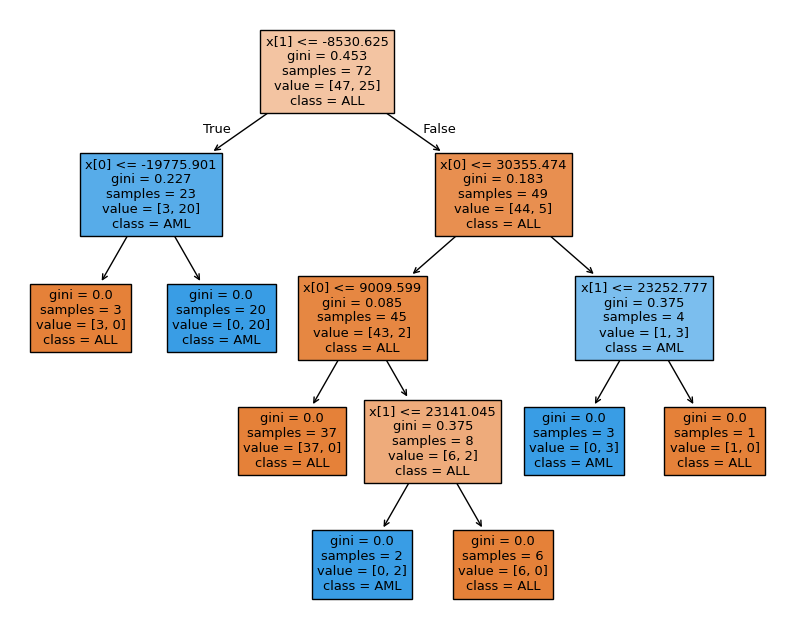

Top 3 components used
Training Accuracy: 1.00


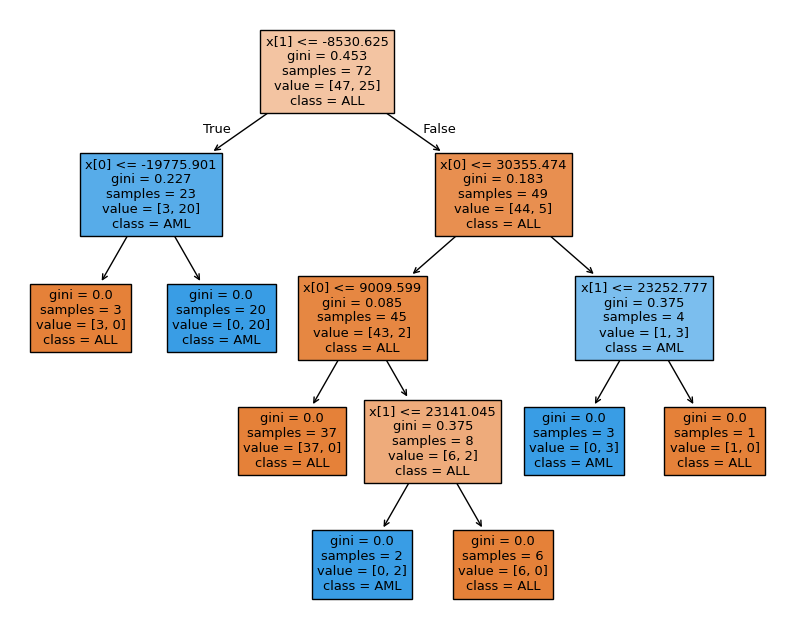

Top 4 components used
Training Accuracy: 1.00


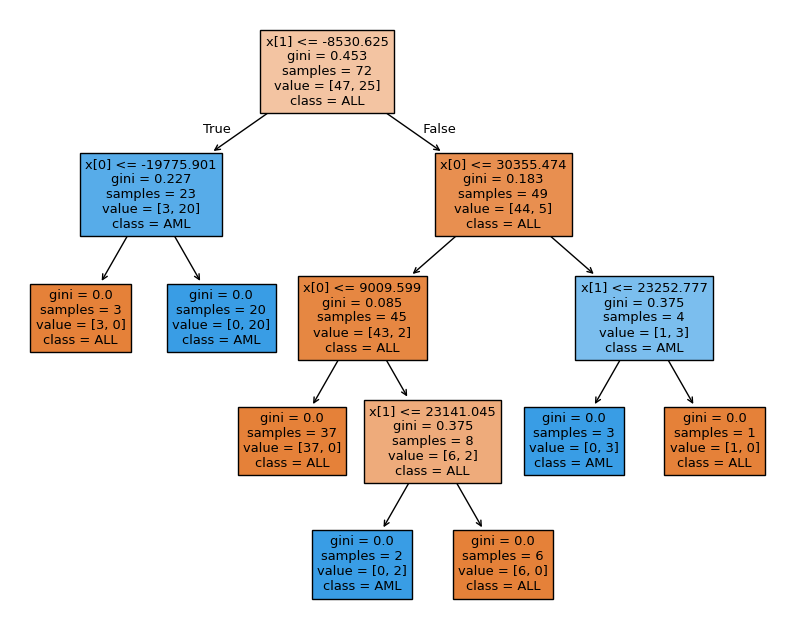

Top 5 components used
Training Accuracy: 1.00


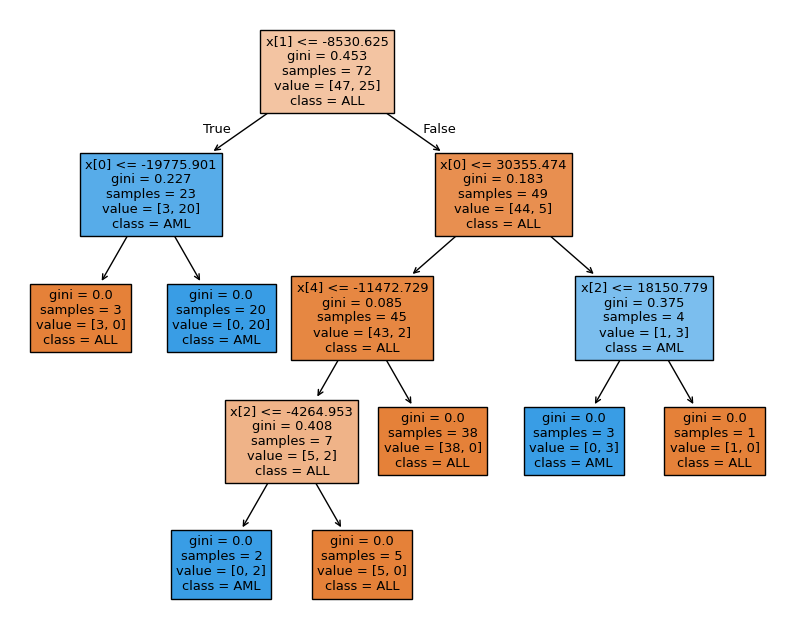

Top 6 components used
Training Accuracy: 1.00


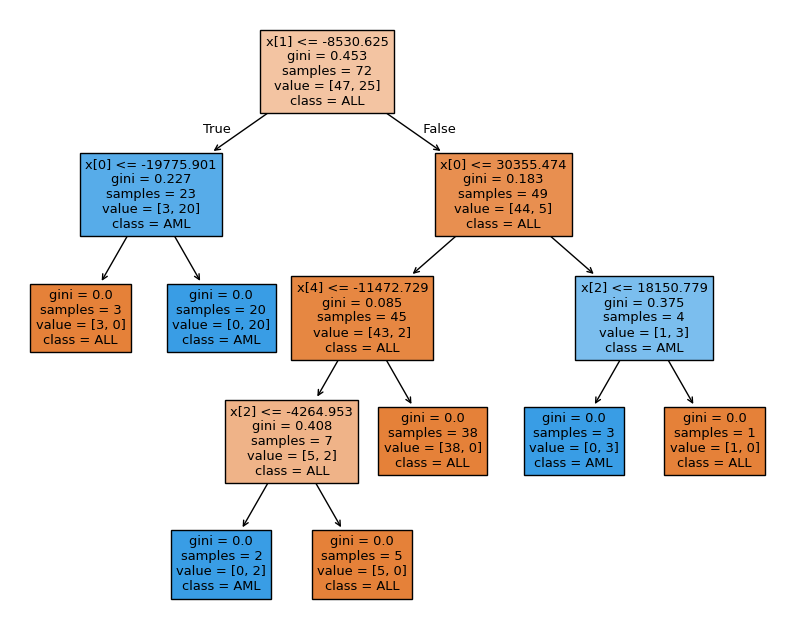

Top 7 components used
Training Accuracy: 1.00


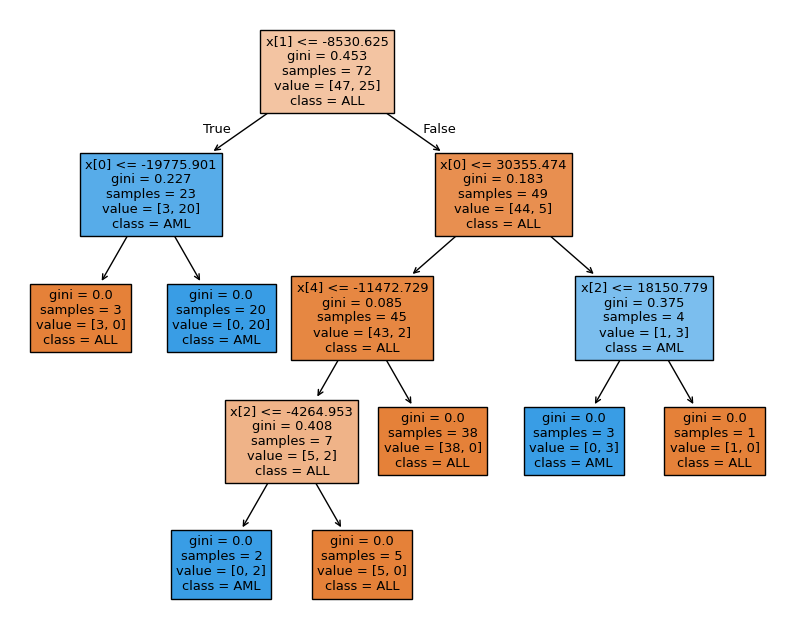

Top 8 components used
Training Accuracy: 1.00


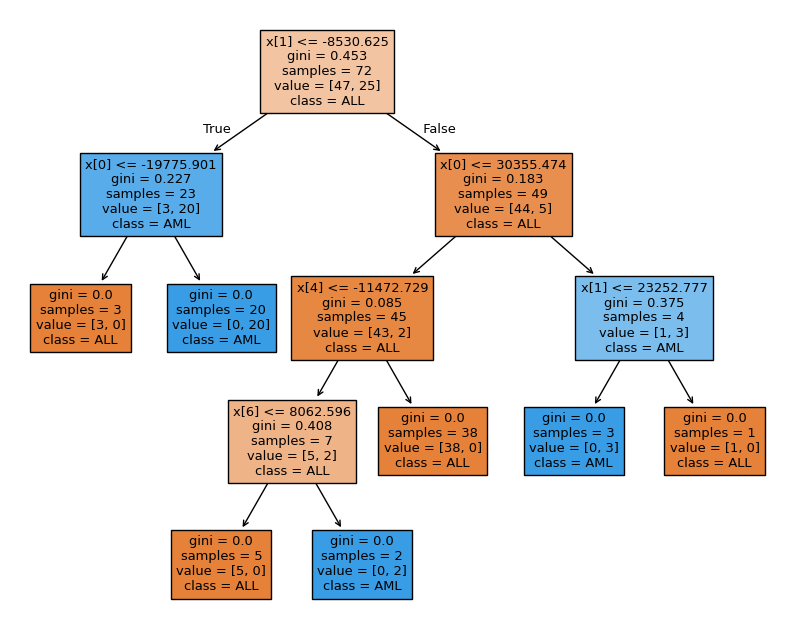

Top 9 components used
Training Accuracy: 1.00


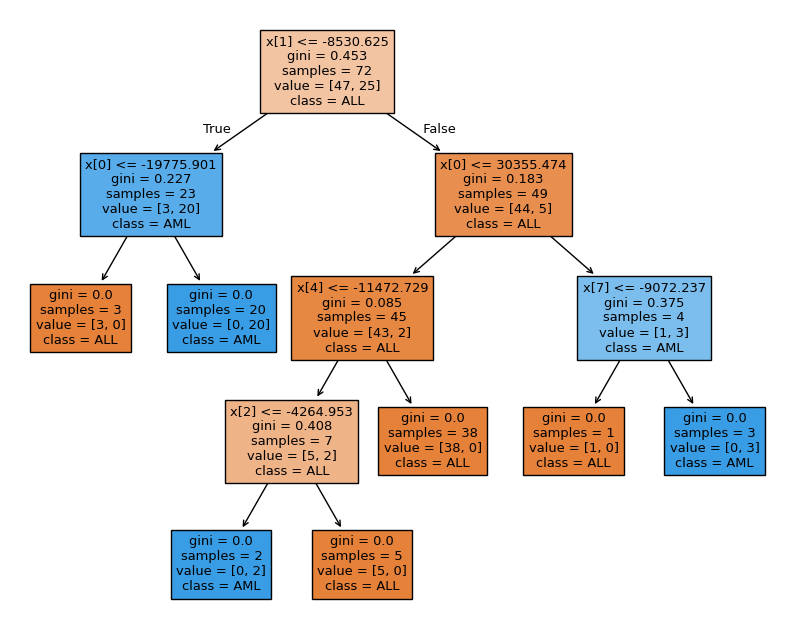

Top 10 components used
Training Accuracy: 1.00


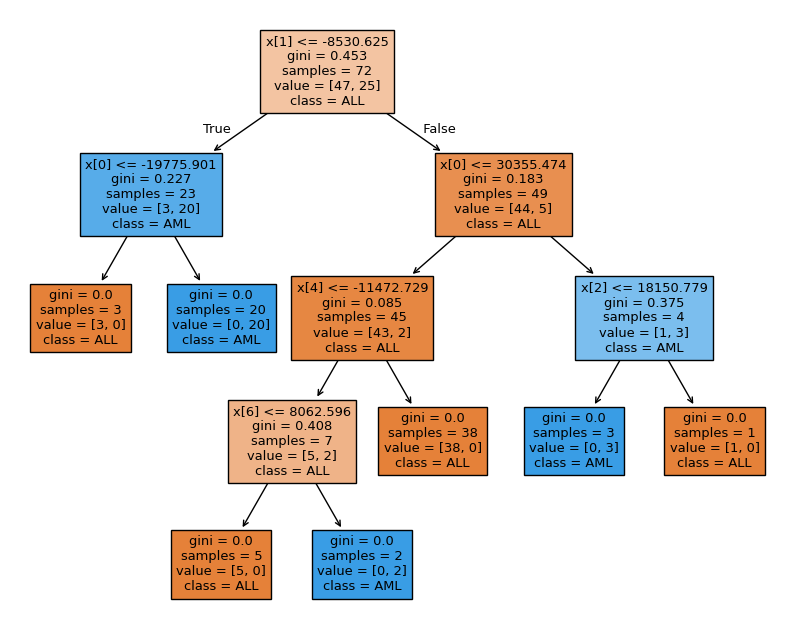

In [97]:
tree_list = []
scores_list = []
for k in range(1,11):
    genes_pca = pca.transform(genes)[:,:k]

    tree = DecisionTreeClassifier()
    tree.fit(genes_pca, labels)
    train_acc = tree.score(genes_pca,labels)
    tree_list.append(tree)
    scores_list.append(train_acc)

    print(f"Top {k} components used")
    print(f"Training Accuracy: {train_acc:.2f}")
    plt.figure(figsize=(10,8))
    plot_tree(tree, filled=True, class_names=label_names)
    plt.show()

Best tree according to Occam razor:
Top 2 components used
Training Accuracy: 1.00
Depth: 4.00
Number of leaves: 7.00


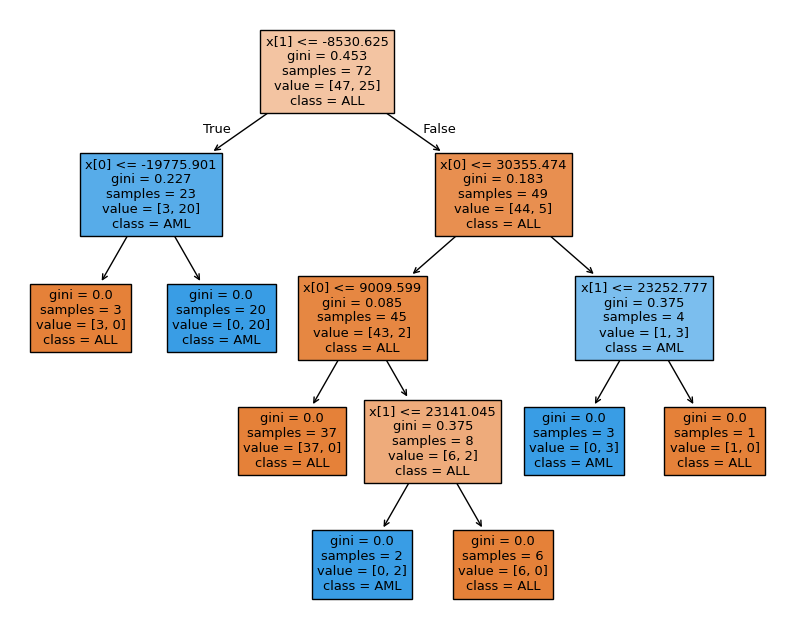

In [100]:
best_tree = None
best_acc = 0
best_depth = sys.maxsize
best_leaves = sys.maxsize
components = 0

for i in range(0,len(tree_list)):
    tree = tree_list[i]
    acc = scores_list[i]
    depth = tree.get_depth()
    leaves = tree.get_n_leaves()
    if (acc > best_acc) or (acc == best_acc and depth < best_depth) or (acc == best_acc and depth == best_depth and leaves < best_leaves):
        best_tree = tree
        best_acc = acc
        best_depth = depth
        best_leaves = leaves
        components = i + 1

print("Best tree according to Occam razor:")
print(f"Top {components} components used")
print(f"Training Accuracy: {best_acc:.2f}")
print(f"Depth: {best_depth:.2f}")
print(f"Number of leaves: {best_leaves:.2f}")
plt.figure(figsize=(10,8))
plot_tree(best_tree, filled=True, class_names=label_names)
plt.show()

        

In [99]:
# Crossvalidation 5 folds
genes_pca = pca.transform(genes)[:,:components]
crossv_tree = DecisionTreeClassifier()
acc_scores = cross_val_score(crossv_tree, genes_pca, labels, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {acc_scores}")
print(f"Mean accuracy: {np.mean(acc_scores):.2f}")
print(f"Standard deviation: {np.std(acc_scores):.2f}")

# Splitting testing and training data
genes_train, genes_test, labels_train, labels_test = train_test_split(genes_pca, labels, test_size=0.2)
test_tree = DecisionTreeClassifier()
test_tree.fit(genes_train,labels_train)
train_acc = test_tree.score(genes_test,labels_test)
print(f"Testing Accuracy: {train_acc:.2f}")

Cross-validation scores: [0.86666667 0.93333333 1.         1.         0.85714286]
Mean accuracy: 0.93
Standard deviation: 0.06
Testing Accuracy: 0.93
